# **Ouroboros EEG-fMRI NF: Predicting EEG activity, fMRI activity and NF scores**

#### Version: 28th October 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

*02: Classification* (all classification models except neural networks)

***03: Neural Networks***

*04: Regression on fMRI Data*

*05: Regression on EEG Data*

*06: Results*

==============================================================================================

### Notebook 03

# **Neural Networks**

## **1. Introduction to Neural Networks**

### 1.1 Objective

The objective of this project is to **explore several ways to apply machine learning models to a given EEG-fMRI NF dataset, and to evaluate which ones result in interesting predictions**. In this Notebook, we will focus on neural networks, and apply them to the fMRI data with the original voxel size, and the EEG bandpowers obtained from all channels, for a single subject. Like in the previous Notebook, we will evaluate if our machine learning models are able to predict the **brain state** of the subject, i.e. when he/she is at rest versus when he/she is performing the NF task. This time, we will also take a step further, and see if we can predict the specific experimental block of 20 seconds during which the fMRI image was acquired or the EEG bandpowers computed, and if we can discriminate between the beginning and the end of the rest and task blocks. 

### 1.2 Models

We will use **dense neural networks**, with one or two layers, and store the test score. For the neural networks with two layers, we will add both a dropout and a L2 regularization to the hidden layer. 

### 1.3 Data import

Here we import the **fMRI data with the original voxel size** and the **EEG bandpowers obtained from all channels**, for a single subject. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the raw data path. 
data_path = '../ouroboros_eeg-fmri_nf_raw_data/'

# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_nf_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(10):
    if subject_index < 9:
        subjects.append('sub-xp10' + str(subject_index + 1))
    else:
        subjects.append('sub-xp1' + str(subject_index + 1))

print(subjects)

['sub-xp101', 'sub-xp102', 'sub-xp103', 'sub-xp104', 'sub-xp105', 'sub-xp106', 'sub-xp107', 'sub-xp108', 'sub-xp109', 'sub-xp110']


In [4]:
# Define an example subject. 
subject_index = subjects[0]
subject_index

'sub-xp101'

In [5]:
# Load the fMRI data with the original voxel size for this subject. 
with np.load(preprocessed_data_path + 'predictors_fMRI.npz', allow_pickle = False) as npz_file:
    predictors_fMRI_single_subject = npz_file['sub_' + str(subjects.index(subject_index) + 1)]
    
# Display the shape of the array. 
predictors_fMRI_single_subject.shape

(106, 106, 32, 200)

In [6]:
# Load the data, and retrieve the number and position of non-NaN voxels per scan. 
image_data = predictors_fMRI_single_subject
non_nan_indexes = ~np.isnan(image_data[:, :, :, 0])
nb_non_nan = np.sum(non_nan_indexes)

# Retrieve the number of scans, then create a NumPy array with one row per scan and one column per non-NaN voxel. 
nb_scans = image_data.shape[3]
predictors_fMRI_single_subject_flatten = np.empty((nb_scans, nb_non_nan))

# Fill in the array. 
for scan in range(nb_scans):
    flatten_image = image_data[:, :, :, scan].flatten()
    flatten_image = flatten_image[~np.isnan(flatten_image)]
    predictors_fMRI_single_subject_flatten[scan, :] = flatten_image
    
# Display the shape of the array. 
predictors_fMRI_single_subject_flatten.shape

(200, 100674)

In [7]:
# Load the EEG predictors with all channels for this subject. 
with open(preprocessed_data_path + 'predictors_EEG_single_subject_all_channels_200_samples.p', 'rb') as file:
    predictors_EEG_single_subject_all_channels_200_samples = pickle.load(file)

# Display the shape of the array. 
predictors_EEG_single_subject_all_channels_200_samples.shape

(200, 320)

In [8]:
# Determine the proportion of the test set for the neural networks models. 
test_set_proportion = 0.2

# Define batch size and validation split. 
batch_size = 96
validation_split = 0.2

In [9]:
# Retrieve and display the events file for the eegfmriNF run. 
events = pd.read_csv(data_path + 'task-eegfmriNF_events.tsv', sep = '\t')
events

,onset,duration,trial_type,stim_file
0,2,20,Rest,Rest_Xp1.png
1,22,20,Task-NF,Task-NF_Xp1.png
2,42,20,Rest,Rest_Xp1.png
3,62,20,Task-NF,Task-NF_Xp1.png
4,82,20,Rest,Rest_Xp1.png
5,102,20,Task-NF,Task-NF_Xp1.png
6,122,20,Rest,Rest_Xp1.png
7,142,20,Task-NF,Task-NF_Xp1.png
8,162,20,Rest,Rest_Xp1.png
9,182,20,Task-NF,Task-NF_Xp1.png


We are interested in the **brain state** variable, i.e. whether the subject is currently in a **rest block** or in a **task block**. Like in the previous Notebook, this target variable is easy to reconstruct. This time, we will also take a step further, and refine our concept of brain state. Specifically, we will try to predict the specific experimental block, and to discriminate between the beginning and the end of the rest and task blocks. The appropriate target variables will be defined in each section. 

## **2. Neural networks based on fMRI data**

### **2.1 Dense neural network: 1-layer**

In the following cells, we **run and compute the predictions from a 1-layer neural network model**. Our target will be the **brain state** variable according to our primary definition, i.e. whether the subject is currently in a rest block or in a task block. 

In [10]:
# Disable warnings. 
import warnings
warnings.filterwarnings('ignore')

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

In [12]:
# Define and display the target variable. 
y = np.repeat(np.tile([0, 1], 10), 10)
print(y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [13]:
# Display the shape of the target variable. 
y.shape

(200,)

In [14]:
# Define the features variables. 
X = predictors_fMRI_single_subject_flatten

# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

In [15]:
# Create a baseline containing only the most frequent value in the train set. 
most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
neural_networks_baseline = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]
neural_networks_baseline

0.425

In [16]:
# Rescale features variables. 
scaler = StandardScaler()
X_tr_standardized = scaler.fit_transform(X_tr)
X_te_standardized = scaler.transform(X_te)

print('Train:', X_tr_standardized.shape)
print('Test:', X_te_standardized.shape)

Train: (160, 100674)
Test: (40, 100674)


In [17]:
# Encode target variable. 
y_tr_encoded = pd.get_dummies(y_tr)
y_te_encoded = pd.get_dummies(y_te)

In [18]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array([0, 1])

In [19]:
# Create model. 
model_dense1 = Sequential()

# Output layer. 
model_dense1.add(Dense(
    units = 2, activation = activations.softmax, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 201350    
Total params: 201,350
Trainable params: 201,350
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Security check: verify that the number of parameters corresponds to what is expected, 
# i.e. the number of features multiplied by the number of target classes, plus the biases for each output neuron. 
model_dense1.count_params() == ((X_tr_standardized.shape[1] * 2) + 2)

True

In [21]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense1 = model_dense1.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 0s 3ms/step - loss: 2.2668 - acc: 0.5078 - val_loss: 1.5004 - val_acc: 0.8125
Epoch 2/100
128/128 [==============================] - 0s 405us/step - loss: 1.9985 - acc: 0.7891 - val_loss: 6.0290 - val_acc: 0.5312
Epoch 3/100
128/128 [==============================] - 0s 492us/step - loss: 4.2095 - acc: 0.6875 - val_loss: 0.3816 - val_acc: 0.8750
Epoch 4/100
128/128 [==============================] - 0s 459us/step - loss: 0.8396 - acc: 0.9141 - val_loss: 0.3765 - val_acc: 0.8750
Epoch 5/100
128/128 [==============================] - 0s 468us/step - loss: 0.2632 - acc: 0.9766 - val_loss: 0.3036 - val_acc: 0.9375
Epoch 6/100
128/128 [==============================] - 0s 551us/step - loss: 0.2535 - acc: 0.9844 - val_loss: 0.2947 - val_acc: 0.9375
Epoch 7/100
128/128 [==============================] - 0s 470us/step - loss: 0.2520 - acc: 0.9844 - val_loss: 0.2953 - val_acc: 0.9375
Epoch 8/100


In [22]:
# Define a function to plot the results of the neural network training. 
def neural_network_graph(history):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

    # Plot loss values. 
    axes[0].plot(history.history['loss'], label = 'train loss', color = 'blue')
    axes[0].plot(history.history['val_loss'], label = 'val loss', color = 'green')
    axes[0].set_title('Validation loss {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_loss'][-3:]) # Take the mean of the last three values. 
    ))
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss value')
    axes[0].legend()

    # Plot accuracy values. 
    axes[1].plot(history.history['acc'], label = 'train acc', color = 'blue')
    axes[1].plot(history.history['val_acc'], label = 'val acc', color = 'green')
    axes[1].set_title('Validation accuracy {:.3f} (mean last 3)'.format(
        np.mean(history.history['val_acc'][-3:]) # Take the mean of the last three values. 
    ))
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend();

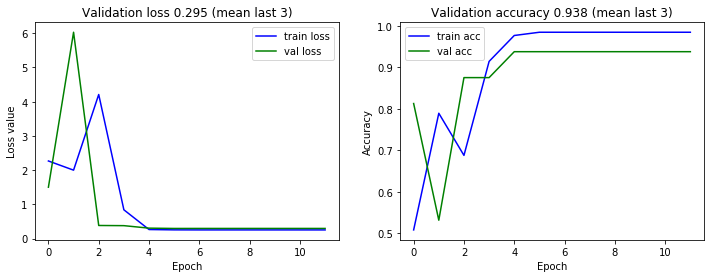

In [23]:
# Display the results. 
neural_network_graph(history_dense1)

In [24]:
# Evaluate test score. 
(test_loss, test_score_dense1) = model_dense1.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense1))

40/40 [==============================] - 0s 251us/step
Test loss: 1.27
Test accuracy: 85.00%


In [25]:
# Compute and display the predictions of the neural network. 
y_pred_dense1 = encoding_order[model_dense1.predict_classes(X_te_standardized)]
y_pred_dense1

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [26]:
# Security check: compute the accuracy from these predictions. 
test_score_dense1_from_pred = np.sum(y_pred_dense1 == y_te) / len(y_te)
test_score_dense1_from_pred

0.85

In [27]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense1_from_pred, 4) == np.round(test_score_dense1, 4)

True

In [28]:
# Display again the baseline. 
neural_networks_baseline

0.425

**Result:** The 1-layer neural network model performs better than the baseline. We can also have a look at the confusion matrix. 

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
# Define a function to generate a Scikit-learn confusion matrix. 
def scikit_learn_confusion_matrix(y_te, y_pred):
    
    # Compute the confusion matrix. 
    labels = ['rest', 'task']
    matrix = confusion_matrix(
        y_true = y_te,
        y_pred = y_pred, 
        labels = labels
    )

    # Return confusion matrix as a DataFrame. 
    matrix_df = pd.DataFrame(data = matrix, columns = labels, index = labels)
    matrix_df.columns.name = 'Predictions'
    matrix_df.index.name = 'True class'
    return matrix_df

In [31]:
# Rename the labels. 
y_te_renamed = np.array(['rest', 'task'])[y_te]
y_pred_dense1_renamed = np.array(['rest', 'task'])[y_pred_dense1]

# Display a Scikit-learn confusion matrix. 
confusion_matrix_dense1 = scikit_learn_confusion_matrix(y_te_renamed, y_pred_dense1_renamed)
confusion_matrix_dense1

Predictions,rest,task
True class,,
rest,13,4
task,2,21


### **2.2 Dense neural network: 2-layer**

In the following cells, we **run and compute the predictions from a 2-layer neural network model**. We add both a dropout and a L2 regularization to the hidden layer. The number of units in the hidden layer was defined by trial and error. For the dropout and the regularization parameters, we simply use values that seem widely used by the machine learning community. Our target will be the **brain state** variable according to our primary definition, i.e. whether the subject is currently in a rest block or in a task block. 

In [32]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [33]:
# Create model. 
model_dense2 = Sequential()

# Hidden layer. 
model_dense2.add(Dense(
    units = 128, activation = activations.relu, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_dense2.add(Dropout(0.5, seed = 0))

# Output layer. 
model_dense2.add(Dense(
    units = 2, activation = activations.softmax,
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12886400  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 12,886,658
Trainable params: 12,886,658
Non-trainable params: 0
_________________________________________________________________


In [34]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense2 = model_dense2.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 2s 13ms/step - loss: 3.7366 - acc: 0.5391 - val_loss: 6.4193 - val_acc: 0.6875
Epoch 2/100
128/128 [==============================] - 0s 2ms/step - loss: 6.4421 - acc: 0.6172 - val_loss: 4.7447 - val_acc: 0.7500
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 3.9598 - acc: 0.8203 - val_loss: 3.4793 - val_acc: 0.8125
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 3.1637 - acc: 0.8828 - val_loss: 3.0286 - val_acc: 0.8438
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 3.6164 - acc: 0.8594 - val_loss: 2.9704 - val_acc: 0.8438
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 2.8975 - acc: 0.9141 - val_loss: 3.0635 - val_acc: 0.8438
Epoch 7/100
128/128 [==============================] - 0s 2ms/step - loss: 2.8009 - acc: 0.9453 - val_loss: 2.8806 - val_acc: 0.8750
Epoch 8/100
128/128 [==

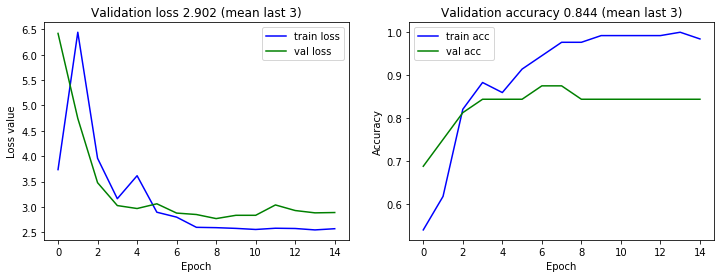

In [35]:
# Display the results. 
neural_network_graph(history_dense2)

In [36]:
# Evaluate test score. 
(test_loss, test_score_dense2) = model_dense2.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense2))

40/40 [==============================] - 0s 562us/step
Test loss: 2.85
Test accuracy: 87.50%


In [37]:
# Compute and display the predictions of the neural network. 
y_pred_dense2 = encoding_order[model_dense2.predict_classes(X_te_standardized)]
y_pred_dense2

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [38]:
# Security check: compute the accuracy from these predictions. 
test_score_dense2_from_pred = np.sum(y_pred_dense2 == y_te) / len(y_te)
test_score_dense2_from_pred

0.875

In [39]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense2_from_pred, 4) == np.round(test_score_dense2, 4)

True

In [40]:
# Display again the baseline. 
neural_networks_baseline

0.425

**Result:** The 2-layer neural network model performs better than the baseline. 

In [41]:
# Rename the labels. 
y_te_renamed = np.array(['rest', 'task'])[y_te]
y_pred_dense2_renamed = np.array(['rest', 'task'])[y_pred_dense2]

# Display a Scikit-learn confusion matrix. 
confusion_matrix_dense2 = scikit_learn_confusion_matrix(y_te_renamed, y_pred_dense2_renamed)
confusion_matrix_dense2

Predictions,rest,task
True class,,
rest,14,3
task,2,21


### **2.3 Dense neural network: 2-layer, target: blocks**

In the following cells, we **run and compute the predictions from a 2-layer neural network model**. Our target will be the **blocks** of the eegfmriNF run. Here, our objective is to find out if our neural networks can discriminate between the individual blocks of 20 seconds, and not just between the rest condition and the task condition. Since we have a larger number of target values, we will perform a train-test split with stratification. 

In [42]:
# Define and display the new target variable. 
y = np.repeat(range(20), 10)
print(y)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19]


In [43]:
# Display the shape of the target variable. 
y.shape

(200,)

In [44]:
# Store the number of different target values. 
nb_target_values = np.unique(y).shape[0]
nb_target_values

20

In [45]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion, stratify = y)

In [46]:
# Create a baseline containing only the most frequent value in the train set. 
most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
neural_networks_baseline3 = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]
neural_networks_baseline3

0.05

In [47]:
# Rescale features variables. 
scaler = StandardScaler()
X_tr_standardized = scaler.fit_transform(X_tr)
X_te_standardized = scaler.transform(X_te)

print('Train:', X_tr_standardized.shape)
print('Test:', X_te_standardized.shape)

Train: (160, 100674)
Test: (40, 100674)


In [48]:
# Encode target variable. 
y_tr_encoded = pd.get_dummies(y_tr)
y_te_encoded = pd.get_dummies(y_te)

In [49]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [50]:
# Create model. 
model_dense3 = Sequential()

# Hidden layer. 
model_dense3.add(Dense(
    units = 128, activation = activations.relu, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_dense3.add(Dropout(0.5, seed = 0))

# Output layer. 
model_dense3.add(Dense(
    units = nb_target_values, activation = activations.softmax,
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense3.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               12886400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
Total params: 12,888,980
Trainable params: 12,888,980
Non-trainable params: 0
_________________________________________________________________


In [51]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense3 = model_dense3.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 2s 12ms/step - loss: 6.3603 - acc: 0.0859 - val_loss: 6.9727 - val_acc: 0.1562
Epoch 2/100
128/128 [==============================] - 0s 2ms/step - loss: 5.4589 - acc: 0.3828 - val_loss: 4.6807 - val_acc: 0.5625
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 3.7932 - acc: 0.7266 - val_loss: 3.9113 - val_acc: 0.6250
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 3.5571 - acc: 0.8125 - val_loss: 4.3562 - val_acc: 0.5625
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 2.9862 - acc: 0.8672 - val_loss: 4.4685 - val_acc: 0.4375
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 2.9036 - acc: 0.8906 - val_loss: 4.1310 - val_acc: 0.4688
Epoch 7/100
128/128 [==============================] - 0s 2ms/step - loss: 2.7067 - acc: 0.9453 - val_loss: 4.4807 - val_acc: 0.5625
Epoch 8/100
128/128 [==

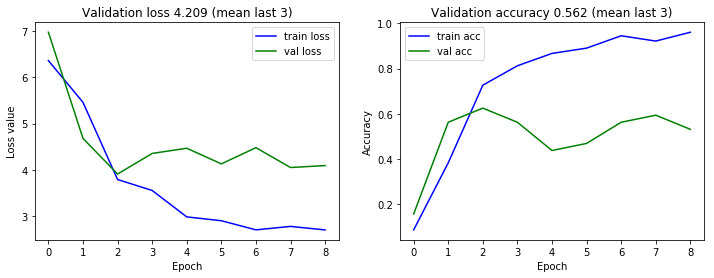

In [52]:
# Display the results. 
neural_network_graph(history_dense3)

In [53]:
# Evaluate test score. 
(test_loss, test_score_dense3) = model_dense3.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense3))

40/40 [==============================] - 0s 591us/step
Test loss: 4.03
Test accuracy: 67.50%


In [54]:
# Compute and display the predictions of the neural network. 
y_pred_dense3 = encoding_order[model_dense3.predict_classes(X_te_standardized)]
y_pred_dense3

array([ 4,  5,  1,  9,  7, 11,  3,  3, 18, 15, 15,  2, 16, 15, 17,  1, 15,
        2,  9,  4,  8, 18,  2, 16, 16,  7, 13, 13, 11, 13, 18, 11, 16,  6,
        5, 18,  0, 19, 19,  9])

In [55]:
# Security check: compute the accuracy from these predictions. 
test_score_dense3_from_pred = np.sum(y_pred_dense3 == y_te) / len(y_te)
test_score_dense3_from_pred

0.675

In [56]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense3_from_pred, 4) == np.round(test_score_dense3, 4)

True

In [57]:
# Display again the baseline. 
neural_networks_baseline3

0.05

**Result:** The 2-layer neural network model performs better than the baseline. 

### **2.4 Dense neural network: 2-layer, target: block positions**

In the following cells, we **run and compute the predictions from a 2-layer neural network model**. Our target will be the **block positions** of the eegfmriNF run. Here, our objective is to find out if our neural networks can discriminate not only between the rest and task blocks, but also between the beginning and the end of these blocks. Again, we will perform a train-test split with stratification. 

In [58]:
# Define and display the new target variable. 
y = np.tile(np.repeat([0, 1, 2, 3], 5), 10)
print(y)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3
 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2
 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2
 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1
 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0
 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


In [59]:
# Display the shape of the target variable. 
y.shape

(200,)

In [60]:
# Store the number of different target values. 
nb_target_values = np.unique(y).shape[0]
nb_target_values

4

In [61]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion, stratify = y)

In [62]:
# Create a baseline containing only the most frequent value in the train set. 
most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
neural_networks_baseline4 = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]
neural_networks_baseline4

0.25

In [63]:
# Rescale features variables. 
scaler = StandardScaler()
X_tr_standardized = scaler.fit_transform(X_tr)
X_te_standardized = scaler.transform(X_te)

print('Train:', X_tr_standardized.shape)
print('Test:', X_te_standardized.shape)

Train: (160, 100674)
Test: (40, 100674)


In [64]:
# Encode target variable. 
y_tr_encoded = pd.get_dummies(y_tr)
y_te_encoded = pd.get_dummies(y_te)

In [65]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array([0, 1, 2, 3])

In [66]:
# Create model. 
model_dense4 = Sequential()

# Hidden layer. 
model_dense4.add(Dense(
    units = 128, activation = activations.relu, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_dense4.add(Dropout(0.5, seed = 0))

# Output layer. 
model_dense4.add(Dense(
    units = nb_target_values, activation = activations.softmax,
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense4.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               12886400  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 516       
Total params: 12,886,916
Trainable params: 12,886,916
Non-trainable params: 0
_________________________________________________________________


In [67]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense4 = model_dense4.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 2s 13ms/step - loss: 5.2176 - acc: 0.3047 - val_loss: 8.6960 - val_acc: 0.2812
Epoch 2/100
128/128 [==============================] - 0s 2ms/step - loss: 7.4301 - acc: 0.4375 - val_loss: 5.5887 - val_acc: 0.5000
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 4.3064 - acc: 0.7109 - val_loss: 5.2661 - val_acc: 0.5312
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 4.1076 - acc: 0.7891 - val_loss: 4.6164 - val_acc: 0.6562
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 4.2164 - acc: 0.8125 - val_loss: 5.1596 - val_acc: 0.5312
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 3.0882 - acc: 0.8672 - val_loss: 4.0866 - val_acc: 0.4688
Epoch 7/100
128/128 [==============================] - 0s 2ms/step - loss: 2.7386 - acc: 0.9453 - val_loss: 3.7466 - val_acc: 0.6250
Epoch 8/100
128/128 [==

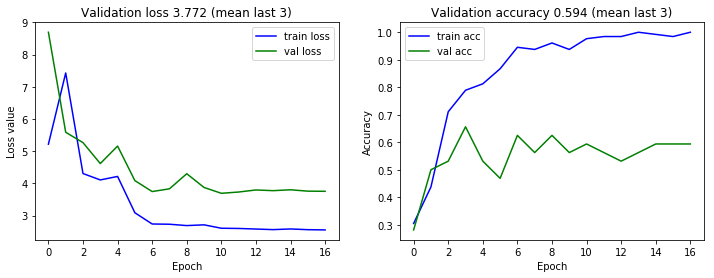

In [68]:
# Display the results. 
neural_network_graph(history_dense4)

In [69]:
# Evaluate test score. 
(test_loss, test_score_dense4) = model_dense4.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense4))

40/40 [==============================] - 0s 595us/step
Test loss: 3.56
Test accuracy: 72.50%


In [70]:
# Compute and display the predictions of the neural network. 
y_pred_dense4 = encoding_order[model_dense4.predict_classes(X_te_standardized)]
y_pred_dense4

array([3, 2, 3, 2, 0, 3, 3, 0, 0, 1, 2, 0, 0, 2, 3, 1, 2, 3, 2, 3, 2, 1,
       3, 1, 1, 0, 0, 2, 0, 0, 3, 2, 0, 1, 0, 3, 2, 3, 0, 3])

In [71]:
# Security check: compute the accuracy from these predictions. 
test_score_dense4_from_pred = np.sum(y_pred_dense4 == y_te) / len(y_te)
test_score_dense4_from_pred

0.725

In [72]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense4_from_pred, 4) == np.round(test_score_dense4, 4)

True

In [73]:
# Display again the baseline. 
neural_networks_baseline4

0.25

**Result:** The 2-layer neural network model performs better than the baseline. 

In [74]:
# Save the results into a .npz file. 
np.savez(results_path + 'neural_networks_with_fMRI_predictors_single_subject.npz', 
         test_score_dense1 = test_score_dense1, 
         test_score_dense2 = test_score_dense2, 
         test_score_dense3 = test_score_dense3, 
         test_score_dense4 = test_score_dense4, 
         y_pred_dense1 = y_pred_dense1, 
         y_pred_dense2 = y_pred_dense2, 
         y_pred_dense3 = y_pred_dense3,
         y_pred_dense4 = y_pred_dense4,
         neural_networks_baseline1 = neural_networks_baseline,
         neural_networks_baseline2 = neural_networks_baseline,
         neural_networks_baseline3 = neural_networks_baseline3,
         neural_networks_baseline4 = neural_networks_baseline4)

## **3. Neural networks based on EEG data**

### **3.1 Dense neural network: 1-layer**

In the following cells, we **run and compute the predictions from a 1-layer neural network model**. Our target will be the **brain state** variable according to our primary definition, i.e. whether the subject is currently in a rest block or in a task block. 

In [75]:
# Define and display the target variable. 
y = np.repeat(np.tile([0, 1], 10), 10)
print(y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [76]:
# Display the shape of the target variable. 
y.shape

(200,)

In [77]:
# Define the features variables. 
X = predictors_EEG_single_subject_all_channels_200_samples

# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

In [78]:
# Create a baseline containing only the most frequent value in the train set. 
most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
neural_networks_baseline = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]
neural_networks_baseline

0.4

In [79]:
# Rescale features variables. 
scaler = StandardScaler()
X_tr_standardized = scaler.fit_transform(X_tr)
X_te_standardized = scaler.transform(X_te)

print('Train:', X_tr_standardized.shape)
print('Test:', X_te_standardized.shape)

Train: (160, 320)
Test: (40, 320)


In [80]:
# Encode target variable. 
y_tr_encoded = pd.get_dummies(y_tr)
y_te_encoded = pd.get_dummies(y_te)

In [81]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array([0, 1])

In [82]:
# Create model. 
model_dense1 = Sequential()

# Output layer. 
model_dense1.add(Dense(
    units = 2, activation = activations.softmax, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 642       
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Security check: verify that the number of parameters corresponds to what is expected, 
# i.e. the number of features multiplied by the number of target classes, plus the biases for each output neuron. 
model_dense1.count_params() == ((X_tr_standardized.shape[1] * 2) + 2)

True

In [84]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense1 = model_dense1.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 0s 4ms/step - loss: 0.8461 - acc: 0.4297 - val_loss: 0.7496 - val_acc: 0.5625
Epoch 2/100
128/128 [==============================] - 0s 45us/step - loss: 0.6815 - acc: 0.6016 - val_loss: 0.6962 - val_acc: 0.5625
Epoch 3/100
128/128 [==============================] - 0s 45us/step - loss: 0.6541 - acc: 0.6094 - val_loss: 0.6781 - val_acc: 0.5625
Epoch 4/100
128/128 [==============================] - 0s 39us/step - loss: 0.6389 - acc: 0.6172 - val_loss: 0.6390 - val_acc: 0.5938
Epoch 5/100
128/128 [==============================] - 0s 30us/step - loss: 0.6251 - acc: 0.6250 - val_loss: 0.6069 - val_acc: 0.5625
Epoch 6/100
128/128 [==============================] - 0s 30us/step - loss: 0.6207 - acc: 0.6406 - val_loss: 0.6154 - val_acc: 0.5938
Epoch 7/100
128/128 [==============================] - 0s 37us/step - loss: 0.6181 - acc: 0.6172 - val_loss: 0.6116 - val_acc: 0.5938
Epoch 8/100
128/12

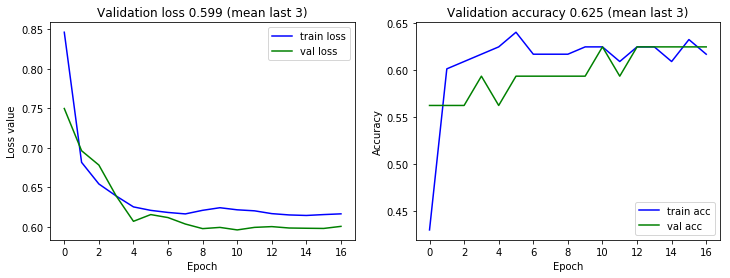

In [85]:
# Display the results. 
neural_network_graph(history_dense1)

In [86]:
# Evaluate test score. 
(test_loss, test_score_dense1) = model_dense1.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense1))

40/40 [==============================] - 0s 24us/step
Test loss: 0.64
Test accuracy: 60.00%


In [87]:
# Compute and display the predictions of the neural network. 
y_pred_dense1 = encoding_order[model_dense1.predict_classes(X_te_standardized)]
y_pred_dense1

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [88]:
# Security check: compute the accuracy from these predictions. 
test_score_dense1_from_pred = np.sum(y_pred_dense1 == y_te) / len(y_te)
test_score_dense1_from_pred

0.6

In [89]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense1_from_pred, 4) == np.round(test_score_dense1, 4)

True

In [90]:
# Display again the baseline. 
neural_networks_baseline

0.4

**Result:** The 1-layer neural network model performs better than the baseline. 

In [91]:
# Rename the labels. 
y_te_renamed = np.array(['rest', 'task'])[y_te]
y_pred_dense1_renamed = np.array(['rest', 'task'])[y_pred_dense1]

# Display a Scikit-learn confusion matrix. 
confusion_matrix_dense1 = scikit_learn_confusion_matrix(y_te_renamed, y_pred_dense1_renamed)
confusion_matrix_dense1

Predictions,rest,task
True class,,
rest,19,5
task,11,5


### **3.2 Dense neural network: 2-layer**

In the following cells, we **run and compute the predictions from a 2-layer neural network model**. We add both a dropout and a L2 regularization to the hidden layer. The number of units in the hidden layer was defined by trial and error. For the dropout and the regularization parameters, we simply use values that seem widely used by the machine learning community. Our target will be the **brain state** variable according to our primary definition, i.e. whether the subject is currently in a rest block or in a task block. 

In [92]:
# Create model. 
model_dense2 = Sequential()

# Hidden layer. 
model_dense2.add(Dense(
    units = 128, activation = activations.relu, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_dense2.add(Dropout(0.5, seed = 0))

# Output layer. 
model_dense2.add(Dense(
    units = 2, activation = activations.softmax,
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 41,346
Trainable params: 41,346
Non-trainable params: 0
_________________________________________________________________


In [93]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense2 = model_dense2.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 1s 5ms/step - loss: 3.4062 - acc: 0.4922 - val_loss: 3.2473 - val_acc: 0.6875
Epoch 2/100
128/128 [==============================] - 0s 81us/step - loss: 3.2838 - acc: 0.5938 - val_loss: 3.2419 - val_acc: 0.6875
Epoch 3/100
128/128 [==============================] - 0s 88us/step - loss: 3.2383 - acc: 0.5937 - val_loss: 3.2455 - val_acc: 0.5938
Epoch 4/100
128/128 [==============================] - 0s 75us/step - loss: 3.2353 - acc: 0.5547 - val_loss: 3.2539 - val_acc: 0.5938
Epoch 5/100
128/128 [==============================] - 0s 101us/step - loss: 3.2758 - acc: 0.5859 - val_loss: 3.2524 - val_acc: 0.6250
Epoch 6/100
128/128 [==============================] - 0s 103us/step - loss: 3.2296 - acc: 0.5781 - val_loss: 3.2584 - val_acc: 0.6250
Epoch 7/100
128/128 [==============================] - 0s 75us/step - loss: 3.2628 - acc: 0.5937 - val_loss: 3.2590 - val_acc: 0.6250
Epoch 8/100
128/

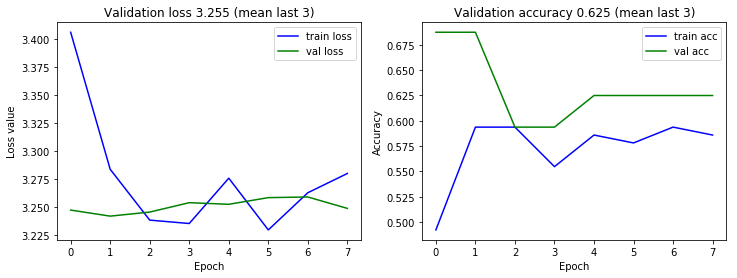

In [94]:
# Display the results. 
neural_network_graph(history_dense2)

In [95]:
# Evaluate test score. 
(test_loss, test_score_dense2) = model_dense2.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense2))

40/40 [==============================] - 0s 38us/step
Test loss: 3.25
Test accuracy: 65.00%


In [96]:
# Compute and display the predictions of the neural network. 
y_pred_dense2 = encoding_order[model_dense2.predict_classes(X_te_standardized)]
y_pred_dense2

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1])

In [97]:
# Security check: compute the accuracy from these predictions. 
test_score_dense2_from_pred = np.sum(y_pred_dense2 == y_te) / len(y_te)
test_score_dense2_from_pred

0.65

In [98]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense2_from_pred, 4) == np.round(test_score_dense2, 4)

True

In [99]:
# Display again the baseline. 
neural_networks_baseline

0.4

**Result:** The 2-layer neural network model performs better than the baseline. 

In [100]:
# Rename the labels. 
y_te_renamed = np.array(['rest', 'task'])[y_te]
y_pred_dense2_renamed = np.array(['rest', 'task'])[y_pred_dense2]

# Display a Scikit-learn confusion matrix. 
confusion_matrix_dense2 = scikit_learn_confusion_matrix(y_te_renamed, y_pred_dense2_renamed)
confusion_matrix_dense2

Predictions,rest,task
True class,,
rest,17,7
task,7,9


### **3.3 Dense neural network: 2-layer, target: blocks**

In the following cells, we **run and compute the predictions from a 2-layer neural network model**. Our target will be the **blocks** of the eegfmriNF run. Here, our objective is to find out if our neural networks can discriminate between the individual blocks of 20 seconds, and not just between the rest condition and the task condition. Since we have a larger number of target values, we will perform a train-test split with stratification. 

In [101]:
# Define and display the new target variable. 
y = np.repeat(range(20), 10)
print(y)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19]


In [102]:
# Display the shape of the target variable. 
y.shape

(200,)

In [103]:
# Store the number of different target values. 
nb_target_values = np.unique(y).shape[0]
nb_target_values

20

In [104]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion, stratify = y)

In [105]:
# Create a baseline containing only the most frequent value in the train set. 
most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
neural_networks_baseline3 = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]
neural_networks_baseline3

0.05

In [106]:
# Rescale features variables. 
scaler = StandardScaler()
X_tr_standardized = scaler.fit_transform(X_tr)
X_te_standardized = scaler.transform(X_te)

print('Train:', X_tr_standardized.shape)
print('Test:', X_te_standardized.shape)

Train: (160, 320)
Test: (40, 320)


In [107]:
# Encode target variable. 
y_tr_encoded = pd.get_dummies(y_tr)
y_te_encoded = pd.get_dummies(y_te)

In [108]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [109]:
# Create model. 
model_dense3 = Sequential()

# Hidden layer. 
model_dense3.add(Dense(
    units = 128, activation = activations.relu, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_dense3.add(Dropout(0.5, seed = 0))

# Output layer. 
model_dense3.add(Dense(
    units = nb_target_values, activation = activations.softmax,
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense3.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               41088     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                2580      
Total params: 43,668
Trainable params: 43,668
Non-trainable params: 0
_________________________________________________________________


In [110]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense3 = model_dense3.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 1s 6ms/step - loss: 6.3970 - acc: 0.0313 - val_loss: 6.1498 - val_acc: 0.1250
Epoch 2/100
128/128 [==============================] - 0s 87us/step - loss: 6.3689 - acc: 0.0469 - val_loss: 6.0152 - val_acc: 0.0938
Epoch 3/100
128/128 [==============================] - 0s 82us/step - loss: 6.1951 - acc: 0.0625 - val_loss: 5.9431 - val_acc: 0.0938
Epoch 4/100
128/128 [==============================] - 0s 77us/step - loss: 6.0041 - acc: 0.0703 - val_loss: 5.8617 - val_acc: 0.1250
Epoch 5/100
128/128 [==============================] - 0s 98us/step - loss: 5.8588 - acc: 0.1016 - val_loss: 5.8325 - val_acc: 0.0938
Epoch 6/100
128/128 [==============================] - 0s 99us/step - loss: 5.7090 - acc: 0.0859 - val_loss: 5.7691 - val_acc: 0.0938
Epoch 7/100
128/128 [==============================] - 0s 85us/step - loss: 5.8440 - acc: 0.1016 - val_loss: 5.7258 - val_acc: 0.1250
Epoch 8/100
128/12

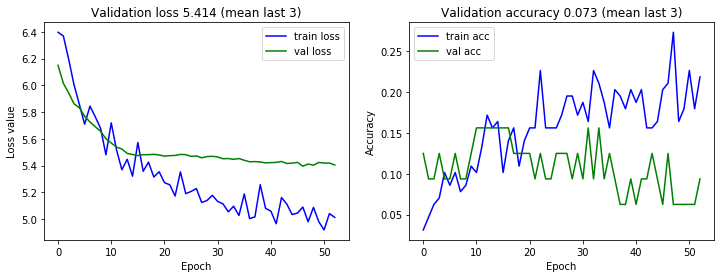

In [111]:
# Display the results. 
neural_network_graph(history_dense3)

In [112]:
# Evaluate test score. 
(test_loss, test_score_dense3) = model_dense3.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense3))

40/40 [==============================] - 0s 41us/step
Test loss: 5.39
Test accuracy: 12.50%


In [113]:
# Compute and display the predictions of the neural network. 
y_pred_dense3 = encoding_order[model_dense3.predict_classes(X_te_standardized)]
y_pred_dense3

array([ 0, 11,  0,  5, 12,  2, 16,  2, 18,  0, 12, 11, 14, 18, 12, 16, 18,
       12,  0,  7,  3,  0, 10, 18,  2, 15,  0, 18, 11,  7,  2,  0, 16,  3,
       12,  2,  5, 12,  5,  7])

In [114]:
# Security check: compute the accuracy from these predictions. 
test_score_dense3_from_pred = np.sum(y_pred_dense3 == y_te) / len(y_te)
test_score_dense3_from_pred

0.125

In [115]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense3_from_pred, 4) == np.round(test_score_dense3, 4)

True

In [116]:
# Display again the baseline. 
neural_networks_baseline3

0.05

**Result:** The 2-layer neural network model performs better than the baseline. 

### **3.4 Dense neural network: 2-layer, target: block positions**

In the following cells, we **run and compute the predictions from a 2-layer neural network model**. Our target will be the **block positions** of the eegfmriNF run. Here, our objective is to find out if our neural networks can discriminate not only between the rest and task blocks, but also between the beginning and the end of these blocks. Again, we will perform a train-test split with stratification. 

In [117]:
# Define and display the new target variable. 
y = np.tile(np.repeat([0, 1, 2, 3], 5), 10)
print(y)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3
 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2
 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2
 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1
 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0
 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


In [118]:
# Display the shape of the target variable. 
y.shape

(200,)

In [119]:
# Store the number of different target values. 
nb_target_values = np.unique(y).shape[0]
nb_target_values

4

In [120]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion, stratify = y)

In [121]:
# Create a baseline containing only the most frequent value in the train set. 
most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
neural_networks_baseline4 = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]
neural_networks_baseline4

0.25

In [122]:
# Rescale features variables. 
scaler = StandardScaler()
X_tr_standardized = scaler.fit_transform(X_tr)
X_te_standardized = scaler.transform(X_te)

print('Train:', X_tr_standardized.shape)
print('Test:', X_te_standardized.shape)

Train: (160, 320)
Test: (40, 320)


In [123]:
# Encode target variable. 
y_tr_encoded = pd.get_dummies(y_tr)
y_te_encoded = pd.get_dummies(y_te)

In [124]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array([0, 1, 2, 3])

In [125]:
# Create model. 
model_dense4 = Sequential()

# Hidden layer. 
model_dense4.add(Dense(
    units = 128, activation = activations.relu, input_dim = X_tr_standardized.shape[1],
    kernel_initializer = initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_dense4.add(Dropout(0.5, seed = 0))

# Output layer. 
model_dense4.add(Dense(
    units = nb_target_values, activation = activations.softmax,
    kernel_initializer = initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Define loss function, optimizer and metrics to track during training. 
model_dense4.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

# Print network summary. 
model_dense4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               41088     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 516       
Total params: 41,604
Trainable params: 41,604
Non-trainable params: 0
_________________________________________________________________


In [126]:
# End training when accuracy stops improving. 
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Fit model. 
history_dense4 = model_dense4.fit(
    x = X_tr_standardized, y = y_tr_encoded,
    validation_split = validation_split, batch_size = batch_size, epochs = 100,
    shuffle = True, callbacks = [early_stopping]
)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 1s 6ms/step - loss: 4.7653 - acc: 0.2188 - val_loss: 4.9594 - val_acc: 0.2500
Epoch 2/100
128/128 [==============================] - 0s 90us/step - loss: 4.4623 - acc: 0.2187 - val_loss: 4.8082 - val_acc: 0.2812
Epoch 3/100
128/128 [==============================] - 0s 88us/step - loss: 4.2230 - acc: 0.2578 - val_loss: 4.6794 - val_acc: 0.3438
Epoch 4/100
128/128 [==============================] - 0s 93us/step - loss: 4.3995 - acc: 0.2187 - val_loss: 4.6035 - val_acc: 0.2812
Epoch 5/100
128/128 [==============================] - 0s 95us/step - loss: 4.1596 - acc: 0.3047 - val_loss: 4.4972 - val_acc: 0.2812
Epoch 6/100
128/128 [==============================] - 0s 70us/step - loss: 4.1736 - acc: 0.2422 - val_loss: 4.3983 - val_acc: 0.2812
Epoch 7/100
128/128 [==============================] - 0s 67us/step - loss: 4.0744 - acc: 0.3281 - val_loss: 4.3165 - val_acc: 0.2500
Epoch 8/100
128/12

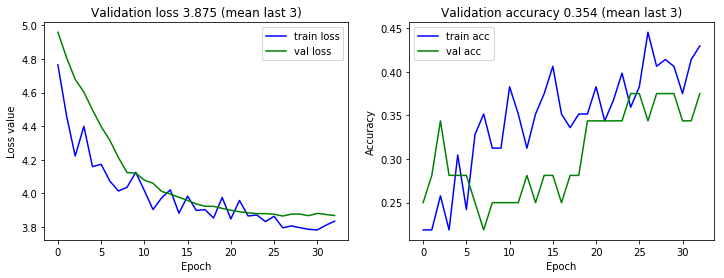

In [127]:
# Display the results. 
neural_network_graph(history_dense4)

In [128]:
# Evaluate test score. 
(test_loss, test_score_dense4) = model_dense4.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100 * test_score_dense4))

40/40 [==============================] - 0s 41us/step
Test loss: 3.82
Test accuracy: 32.50%


In [129]:
# Compute and display the predictions of the neural network. 
y_pred_dense4 = encoding_order[model_dense4.predict_classes(X_te_standardized)]
y_pred_dense4

array([1, 1, 3, 1, 3, 0, 3, 0, 0, 0, 0, 3, 0, 2, 3, 0, 0, 1, 3, 0, 3, 2,
       0, 0, 0, 3, 3, 3, 3, 3, 2, 2, 1, 3, 2, 0, 1, 3, 0, 2])

In [130]:
# Security check: compute the accuracy from these predictions. 
test_score_dense4_from_pred = np.sum(y_pred_dense4 == y_te) / len(y_te)
test_score_dense4_from_pred

0.325

In [131]:
# Verify if the two accuracies are equal. 
np.round(test_score_dense4_from_pred, 4) == np.round(test_score_dense4, 4)

True

In [132]:
# Display again the baseline. 
neural_networks_baseline4

0.25

**Result:** The 2-layer neural network model performs better than the baseline. 

In [133]:
# Save the results into a .npz file. 
np.savez(results_path + 'neural_networks_with_EEG_predictors_single_subject.npz', 
         test_score_dense1 = test_score_dense1, 
         test_score_dense2 = test_score_dense2, 
         test_score_dense3 = test_score_dense3, 
         test_score_dense4 = test_score_dense4, 
         y_pred_dense1 = y_pred_dense1, 
         y_pred_dense2 = y_pred_dense2, 
         y_pred_dense3 = y_pred_dense3,
         y_pred_dense4 = y_pred_dense4,
         neural_networks_baseline1 = neural_networks_baseline,
         neural_networks_baseline2 = neural_networks_baseline,
         neural_networks_baseline3 = neural_networks_baseline3,
         neural_networks_baseline4 = neural_networks_baseline4)